In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
import glob
import fitsio
from scipy.signal import convolve2d
from scipy.ndimage.filters import gaussian_filter 

In [47]:
def read_vel(file, data_str):
    idl_dict = readsav(file)
    vel = idl_dict[data_str]
    return vel

datadir = '/Users/rattie/Data/Karin/sanity_check/'

## Sanity check FLCT vs Stein simulation

### 1) Load FLCT results (Karin) on drifted series

In [24]:
dts = [1, 3, 6, 9]
lctfiles = sorted(glob.glob(os.path.join(datadir, 'Stein-simulation-series', 'drift_*/flct-km*.save')))
for f in lctfiles:
    print(f)

/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_00/flct-km-Stein-simul-drift_00-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_01/flct-km-Stein-simul-drift_01-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_02/flct-km-Stein-simul-drift_02-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_03/flct-km-Stein-simul-drift_03-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_04/flct-km-Stein-simul-drift_04-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_05/flct-km-Stein-simul-drift_05-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_06/flct-km-Stein-simul-drift_06-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_07/flct-km-Stein-simul-drift_07-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_08/f

In [48]:
vxs = [read_vel(f, 'vx') for f in lctfiles]
print(vxs[0].shape)

(79, 263, 263)


In [31]:
dv = 0.04
vx_rates = np.arange(-0.2, 0.21, dv)
vx_rates[int(len(vx_rates)/2)] = 0
print(vx_rates)

[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2 ]


In [ ]:
vxsmean = np.array([vx[:,10:-10,10:-10].mean(axis=0).mean() for vx in vxs])

#### Load true Stein velocity field

In [132]:
data_dir_stein = '/Users/rattie/Data/Ben/SteinSDO/'
svx_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vy*.fits')))
trange = [0,29]
vx_stein, vy_stein = load_vel_mean((svx_files, svy_files), trange)
unit = 368000 / 60 # m/s
# Get true mean velocity (unit already in m/s)
vx_stein_mean = vx_stein[fov].mean()
print(vx_stein_mean, 'm/s')

-90.40378 m/s


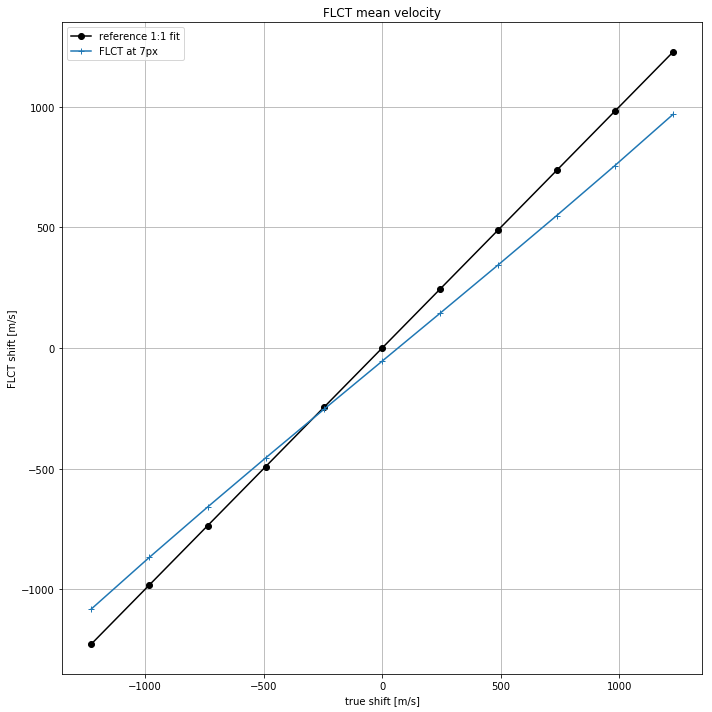

In [130]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(vx_rates*unit, vx_rates*unit, 'k-', marker='o', label='reference 1:1 fit')
ax.plot(vx_rates*unit, vxsmean*unit, marker='+', label = 'FLCT at 7px')
ax.grid(True, axis='both')
plt.xlabel('true shift [m/s]')
plt.ylabel('FLCT shift [m/s]')
plt.legend()
plt.title('FLCT mean velocity')
plt.tight_layout()

### 2) Correlation between velocites from FLCT and Stein MHD simulation (no drift)

In [105]:
def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson

def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy

def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm])
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2

# Select a subfield excluding edge effects
imsize = 263 # actual size is 264 but original size was 263 then padded to 264 to make it even for the Fourier transform
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = 10
fov = np.s_[pad:imsize - pad, pad:imsize-pad]
fwhm = 7

#### Load Stein MHD velocity

In [127]:
# smooth the Stein velocities 
vx_stein_sm, vy_stein_sm = smooth_vel(vx_stein, vy_stein, fwhm, kernel='boxcar') 

#### Load FLCT velocity (zero drift) - Karin

In [119]:
# Index in velocity series where drift is zero
vx_flct = fitsio.read('/Users/rattie/Data/Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma7/FLCT_vx1_000-028.fits')
vy_flct = fitsio.read('/Users/rattie/Data/Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma7/FLCT_vy1_000-028.fits')

#### Compute correlation

In [120]:
c_pearsons = calc_c_pearson(vx_stein_sm, vx_flct, vy_stein_sm, vy_flct, fov=fov) 
print(c_pearsons)

0.8544049358259741
